Realizar la planificación y modelado de una simulacion basado en eventos discretos para identificar los contagios dentro de un establecimiento de estudiantes post COVID-19 para el reingreso de clases. Los pasos para el regreso progresivo a clases se describe a continuación:
* Calcular e Identificar el aforo máximo permitido en la institución educativa.
* Identificar el número de estudiantes y el porcentaje de contagio dentro del contexto poblacional el mismo que se aplicara dentro de la simulación por el contagio.
* Generar la simulación desde la puerta de ingreso y la salida del plantel por día.
* Los estudiantes hacen fila para ingresar al establecimiento y no pueden superar el aforo permitido.
* Realizar con un tiempo de un 1 mes.

In [6]:
import simpy
import random
import matplotlib.pyplot as plt
from scipy import stats 

In [10]:
TASA_CONTAGIO = 0.3 # parametro de forma → bernoulli
AFORO = 400
TIEMPO_EJECUCION = 60 * 6 * 31 # simula un colegio (7am a 1pm)
TIEMPO_CLASES = 60*6

dia = 1
tiempo_dia = 0
contagio_dia = {}

In [11]:
def contagio_bernoulli(tasa_contagio):
    valor = stats.bernoulli(tasa_contagio)
    return valor.rvs(1)
    

Contagios por dia
{1: 176, 2: 170, 3: 186, 4: 180, 5: 181, 6: 179, 7: 188, 8: 169, 9: 165, 10: 161, 11: 176, 12: 174, 13: 166, 14: 184, 15: 164, 16: 163, 17: 173, 18: 175, 19: 168, 20: 156, 21: 175, 22: 168, 23: 172, 24: 180, 25: 173, 26: 189, 27: 179, 28: 182, 29: 169, 30: 177}


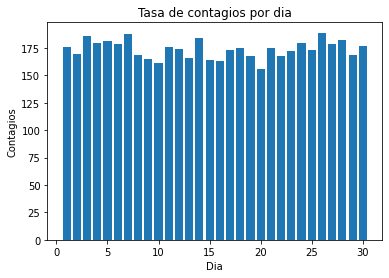

In [12]:
class Colegio(object):
    def __init__(self, env, aforo):
        self.env = env
        self.aforo = simpy.Resource(env, aforo)

    def clases(self,tiempo_clases):
        yield self.env.timeout(tiempo_clases)

def llegada_estudiantes(env, colegio, tasa_contagio,dia):
    with colegio.aforo.request() as aforo:
        
        yield aforo
        contagiado = 0
        yield env.process(colegio.clases(TIEMPO_CLASES))
        #mas tiempo pasa, mas probable es que se contagien
        if (tiempo_dia < 60):
            contagiado = contagio_bernoulli(tasa_contagio)
        elif (tiempo_dia<=60 and tiempo_dia<120):
            contagiado = contagio_bernoulli(tasa_contagio+0.1)
        elif (tiempo_dia<=120 and tiempo_dia<180):
            contagiado = contagio_bernoulli(tasa_contagio+0.2)
        elif (tiempo_dia<=180 and tiempo_dia<240):
            contagiado = contagio_bernoulli(tasa_contagio+0.3)
        elif (tiempo_dia<=240 and tiempo_dia<300):
            contagiado = contagio_bernoulli(tasa_contagio+0.4)
        elif (tiempo_dia<=300 and tiempo_dia<360):
            contagiado = contagio_bernoulli(tasa_contagio+0.5)
        
        if (contagiado == 1):
            if dia in contagio_dia.keys():
                contagio_dia[dia] += 1
            else:
                contagio_dia[dia] = 1

def ejecutar_simulacion(env,aforo):
    global contagio_dia
    global dia
    global tiempo_dia

    colegio = Colegio(env,aforo)

    while True:
        tiempo_dia += 1
        yield env.timeout(1)
        env.process(llegada_estudiantes(env,colegio,TASA_CONTAGIO,dia))

        if tiempo_dia==360:
            dia += 1
            tiempo_dia = 0

env = simpy.Environment()
env.process(ejecutar_simulacion(env,AFORO))
env.run(until=TIEMPO_EJECUCION)

print('Contagios por dia')
print(contagio_dia)

etiqueta = list(contagio_dia.keys())
valores = list(contagio_dia.values())
plt.bar(etiqueta, valores, align="center")
plt.title("Tasa de contagios por dia")
plt.xlabel("Dia")
plt.ylabel("Contagios")
plt.show()